The goal here is to create a "raster plot" that shows the reproducibility of a spike train to different repetitions of different stimulus: a DC current versus noise. 

In particular, we will attempt to replicate Figure 1 of [Mainen & Sejnowski (1995)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.299.8560&rep=rep1&type=pdf) and use computational Neuroscience as a tool to better understanfd neurophysiological observations. 


# Mainen & Sejnowski, 1995

## context

The goal of this first task is to create a "raster plot" that shows the reproducibility of a spike train with repetitions of the same stimulus, as in this work in the [rodent retina](https://laurentperrinet.github.io/2019-04-03_a_course_on_vision_and_modelization/#/1/3) or in the [cat cortex (V1)](https://laurentperrinet.github.io/2019-04-03_a_course_on_vision_and_modelization/#/1/6).

## figure 1

Here, we will attempt to replicate Figure 1 of [Mainen & Sejnowski (1995)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.299.8560&rep=rep1&type=pdf):

![Mainen Sejnowski 1995](http://i.stack.imgur.com/ixnrz.png "figure 1")


QUESTION: write a quick summary of the paper (max 5 lines) and why this result is *a priori* surprising.

# representation of time

## a gentle introduction to python and numpy

In [1]:
dt = .5 # size of the time discretization step

In [2]:
%whos

Variable   Type     Data/Info
-----------------------------
dt         float    0.5


In [3]:
import numpy as np
# help(np)

In [4]:
np.lookfor('binary representation') 

Search results for 'binary representation'
------------------------------------------
numpy.binary_repr
    Return the binary representation of the input number as a string.
numpy.core.setup_common.long_double_representation
    Given a binary dump as given by GNU od -b, look for long double
numpy.base_repr
    Return a string representation of a number in the given base system.
numpy.finfo
    finfo(dtype)
numpy.lookfor
    Do a keyword search on docstrings.
numpy.bitwise_or
    Compute the bit-wise OR of two arrays element-wise.
numpy.left_shift
    Shift the bits of an integer to the left.
numpy.bitwise_and
    Compute the bit-wise AND of two arrays element-wise.
numpy.bitwise_not
    Compute bit-wise inversion, or bit-wise NOT, element-wise.
numpy.bitwise_xor
    Compute the bit-wise XOR of two arrays element-wise.
numpy.right_shift
    Shift the bits of an integer to the right.
numpy.ma.bitwise_or
    Compute the bit-wise OR of two arrays element-wise.
numpy.ma.bitwise_and
    Com

In [5]:
np.lookfor('evenly spaced values')

Search results for 'evenly spaced values'
-----------------------------------------
numpy.arange
    Return evenly spaced values within a given interval.
numpy.ma.arange
    Return evenly spaced values within a given interval.
numpy.linspace
    Return evenly spaced numbers over a specified interval.
numpy.logspace
    Return numbers spaced evenly on a log scale.
numpy.geomspace
    Return numbers spaced evenly on a log scale (a geometric progression).
numpy.trapz
    Integrate along the given axis using the composite trapezoidal rule.
numpy.gradient
    Return the gradient of an N-dimensional array.


In [6]:
time = np.arange(0, 1000, dt)
time = np.linspace(-100, 1000, int(1100/dt))

In [7]:
time

array([-100.        ,  -99.49977262,  -98.99954525, ...,  998.99954525,
        999.49977262, 1000.        ])

In [8]:
time.shape

(2200,)

In [9]:
time[:10]

array([-100.        ,  -99.49977262,  -98.99954525,  -98.49931787,
        -97.9990905 ,  -97.49886312,  -96.99863574,  -96.49840837,
        -95.99818099,  -95.49795362])

In [10]:
time[0], time[1], time[-2], time[-1]

(-100.0, -99.49977262391997, 999.4997726239201, 1000.0)

Creation of a DC current (version one):

In [11]:
start = 0
end = 900
value = 150

def Inp(time=time, start=start, end=end, value=value):
    x=[]
    for t in range(len(time)):
        if start < time[t] < end :
            x.append(value)
        else:
            x.append(0)
    return x

I = Inp(time)

In [12]:
%%timeit
I = Inp(time)

1.26 ms ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Vectorizing the code (version two):

In [13]:
def Inp(time=time, start=start, end=end, value=value):
    I = np.zeros_like(time)
    I[time>start] = value
    I[time>end] = 0
    return I
  
I = Inp(time)

In [14]:
%%timeit
I = Inp(time)

19.5 µs ± 4 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


QUESTION: try to describe why the computation time to create the vector is different in the two versions

## a gentle introduction to matplotlib / pylab / pyplot

Matplotlib is the major library for plotting in the python ecosystem. Import it like this

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 15 # defining the size of plots
phi = (np.sqrt(5)+1)/2 # setting up the golden ratio
phi = phi**2

In [16]:
np.lookfor('bar plot', module='matplotlib.pyplot')

Search results for 'bar plot'
-----------------------------
matplotlib.pyplot.bar
    Make a bar plot.
matplotlib.pyplot.barh
    Make a horizontal bar plot.
matplotlib.pyplot.barbs
    Plot a 2D field of barbs.
matplotlib.pyplot.colorbar
    Add a colorbar to a plot.
matplotlib.pyplot.errorbar
    Plot y versus x as lines and/or markers with attached errorbars.
matplotlib.pyplot.csd
    Plot the cross-spectral density.
matplotlib.pyplot.psd
    Plot the power spectral density.
matplotlib.pyplot.hist
    Plot a histogram.
matplotlib.pyplot.broken_barh
    Plot a horizontal sequence of rectangles.
matplotlib.pyplot.cohere
    Plot the coherence between *x* and *y*.
matplotlib.pyplot.hexbin
    Make a 2D hexagonal binning plot of points *x*, *y*.
matplotlib.pyplot.pcolor
    Create a pseudocolor plot with a non-regular rectangular grid.
matplotlib.pyplot.contour
    Plot contours.
matplotlib.pyplot.contourf
    Plot contours.
matplotlib.pyplot.specgram
    Plot a spectrogram.
matplotlib.

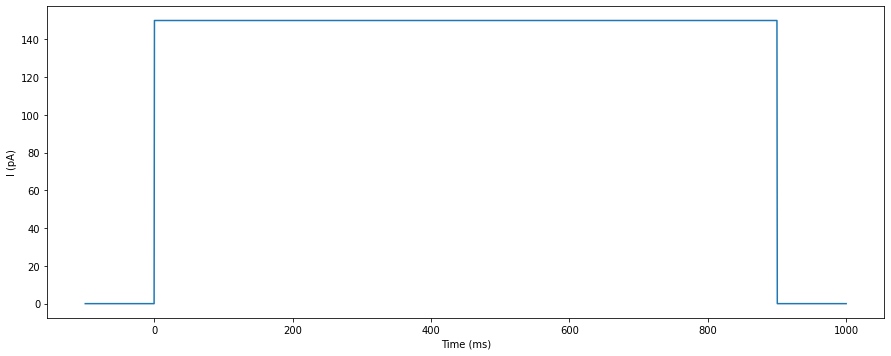

In [17]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width/phi))
ax.plot(time, I)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I (pA)');

QUESTION: re-run this calculation by adjusting the parameters to match figure 1

If the code above looks scary, do not worry - Pythons are loving animals:

* a nice [one-day course in python](https://github.com/NeuromatchAcademy/precourse)
* resources abound  and [an army of geeks are ready to answer to any of your questions](https://stackoverflow.com/questions/tagged/python)

## a simple model of an integrate-and-fire neuron `leaky_IF`

Let's start with this membrane potential equation:

$$
\tau \cdot \frac{dV}{dt} = -(V - V_{rest}) + R*I(t)
$$

with emission of a spike if $V > V_{rest}$, and then $V= V_{rest}$ for $3 ms$.

In [18]:
Vthreshold = -53
Vreset = -80
VRest = -70
Vspike = 30
tau = 30

In [19]:
def leaky_IF(time=time, inp=I, tau=tau, v0=-69, R=0.12, 
             Vthreshold=Vthreshold, Vreset=Vreset, Vspike=Vspike, 
             VRest=VRest):
    V = np.ones_like(time)*v0
    dt = time[1] - time[0]
    for t in range(len(time)-1):
        dV = dt * (-(V[t] - VRest) + R*inp[t])/tau
        V[t+1] = V[t] + dV
        
        if V[t]>Vthreshold:
            V[t+1] = Vspike
        if V[t] == Vspike:
            V[t+1] = Vreset
         
    return V

QUESTION: Set the parameter $R$ to obtain about 10 spikes - what is the interpretation of this parameter and what is the unit of measurement?

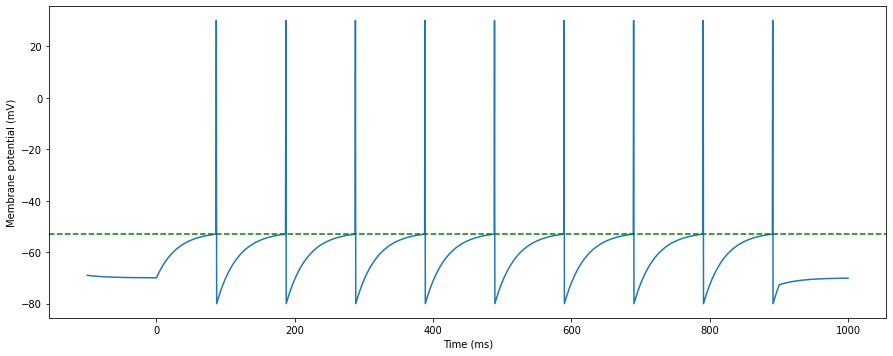

In [20]:
V = leaky_IF(time, I)

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V)
ax.axhline(Vthreshold, c='g', ls='--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)');

QUESTION: What is the effect of $I_0$ on the discharge frequency?

Focus: The linear part of the response

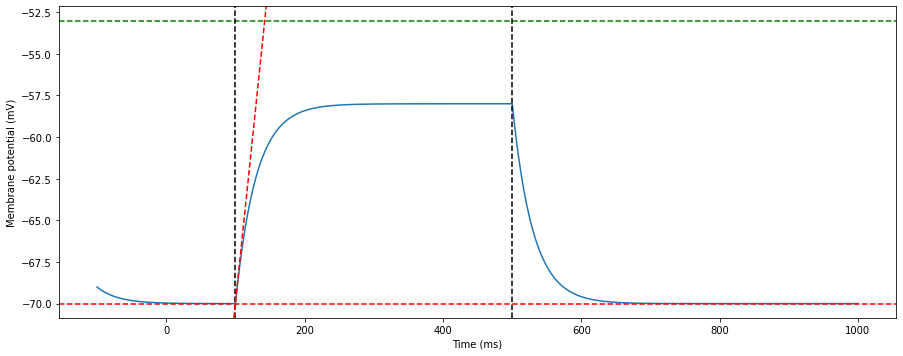

In [21]:
V = leaky_IF(time, Inp(time=time, start=100, end=500, value=100))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V)
ax.axhline(Vthreshold, c='g', ls='--')
ax.axvline(100, c='k', ls='--')
ax.axvline(500, c='k', ls='--')
ax.axhline(VRest, c='r', ls='--')
ax.axline((100, VRest), slope=.12*100/tau,  c='r', ls='--')
ax.set_xlabel('Time (ms)')

ax.set_ylabel('Membrane potential (mV)');

In [22]:
ax.axline?

Signature: ax.axline(xy1, xy2=None, *, slope=None, **kwargs)
Docstring:
Add an infinitely long straight line.

The line can be defined either by two points *xy1* and *xy2*, or
by one point *xy1* and a *slope*.

This draws a straight line "on the screen", regardless of the x and y
scales, and is thus also suitable for drawing exponential decays in
semilog plots, power laws in loglog plots, etc. However, *slope*
should only be used with linear scales; It has no clear meaning for
all other scales, and thus the behavior is undefined. Please specify
the line using the points *xy1*, *xy2* for non-linear scales.

Parameters
----------
xy1, xy2 : (float, float)
    Points for the line to pass through.
    Either *xy2* or *slope* has to be given.
slope : float, optional
    The slope of the line. Either *xy2* or *slope* has to be given.

Returns
-------
`.Line2D`

Other Parameters
----------------
**kwargs
    Valid kwargs are `.Line2D` properties, with the exception of
    'transform':

    Pr

I_0= 125.0


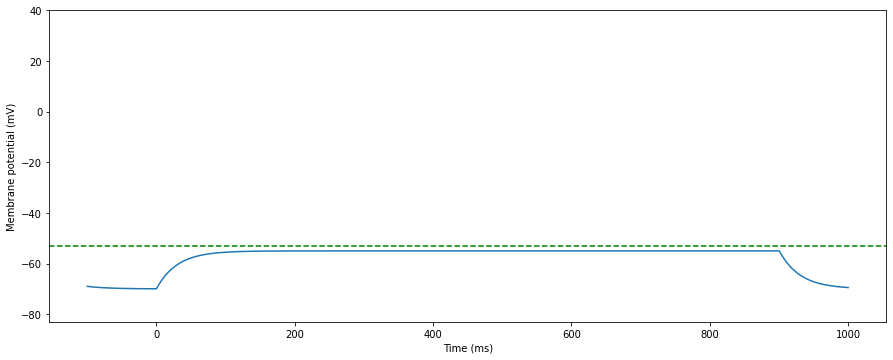

I_0= 168.75


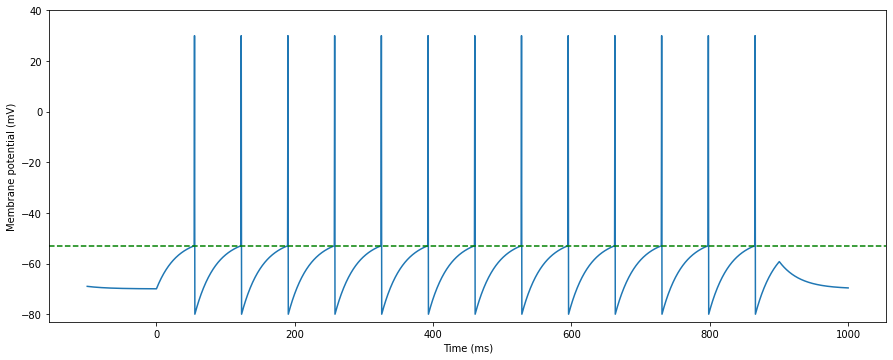

I_0= 212.5


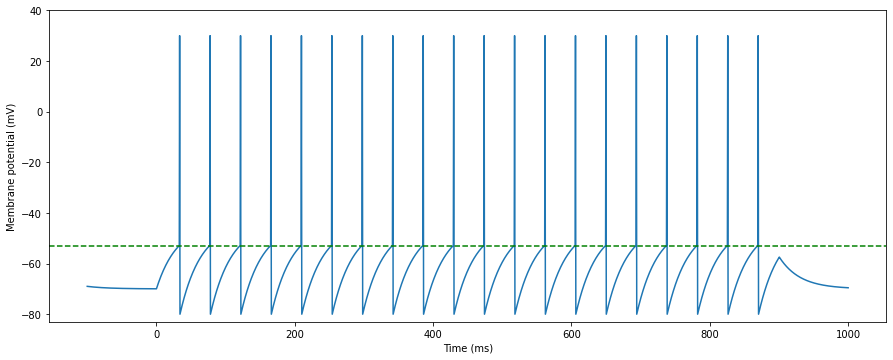

I_0= 256.25


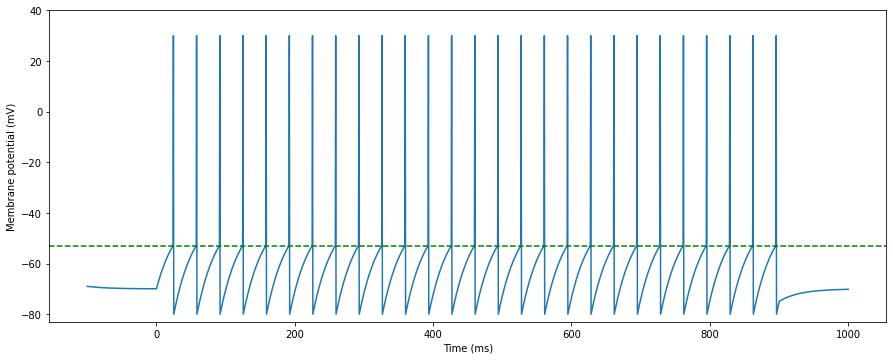

I_0= 300.0


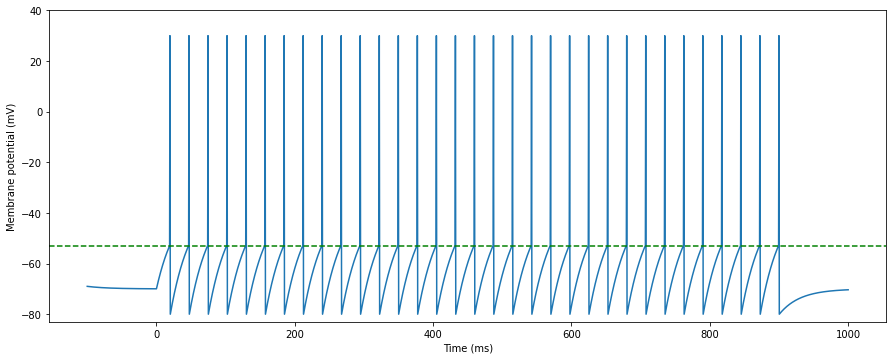

In [23]:
for rho in np.linspace(0.5, 1.2, 5):
    I_0_ = rho*250
    print('I_0=', I_0_)
    V= leaky_IF(time, Inp(value=I_0_))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, V)
    ax.axhline(Vthreshold, c='g', ls='--')
    ax.set_ylim(-83, 40)
    ax.set_ylabel("Membrane potential (mV)")
    ax.set_xlabel('Time (ms)')
    plt.show()

Several tests show that this is perfectly reproducible, unlike figure 1A:

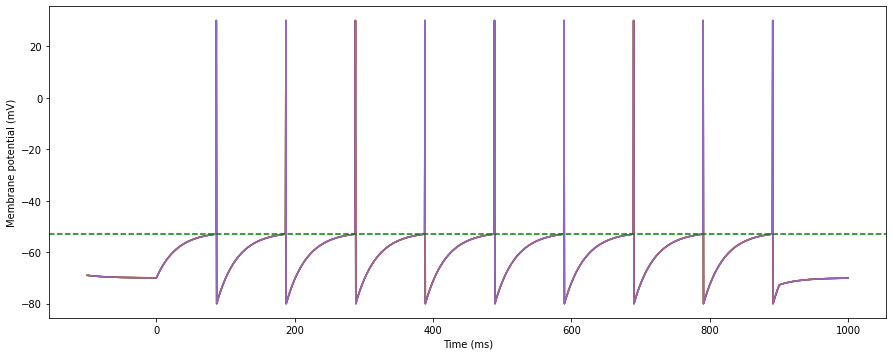

In [24]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF()

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.axhline(Vthreshold, c='g', ls='--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)');

QUESTION: this model seems not to reproduce the results, any explanation?

# Creating a noisy input

A linear scattering model allows you to simply create a noise:

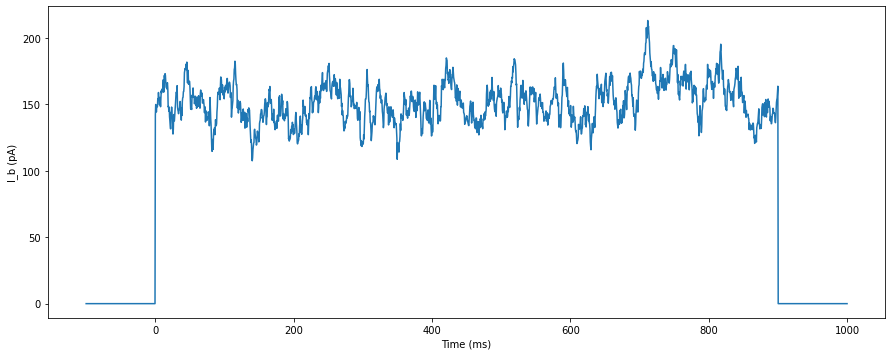

In [25]:
def genNoise(time=time, tau_n=10, I_n=100, I_0=150, start=start, end=end):
    dt = time[1] - time[0]
    x=np.ones_like(time)
    for t in range(len(x)-1):
        n = np.random.randn()*I_n
        x[t+1] = (1-dt/tau_n)*x[t] + (dt*n/tau_n)
    
    x += I_0
    x[time<start], x[time>end] = 0, 0
    
    return x

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, genNoise())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

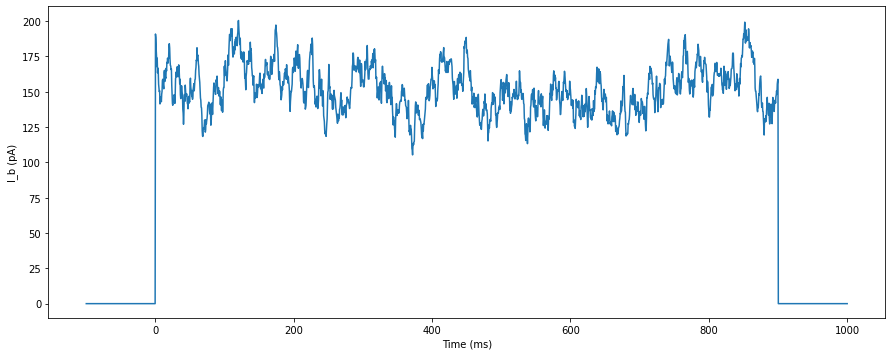

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, genNoise())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

QUESTION: does this model represent well the one in the paper? adjust $I_n$ and $I_0$ to get something that fits better.

## LIF neuron with noisy input

Let's now observe the response of our LIF neuron to this input:

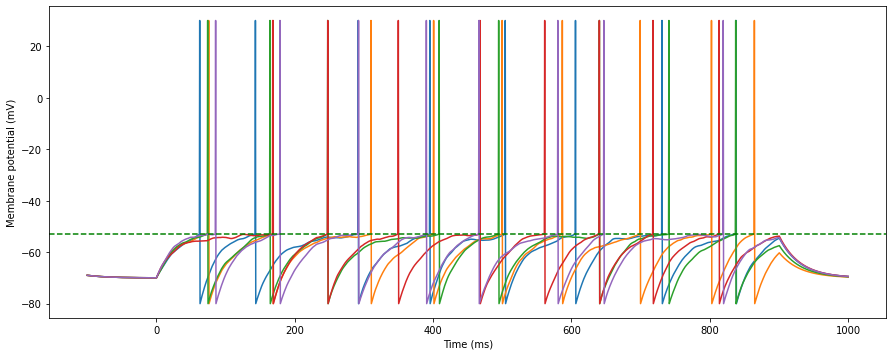

In [27]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, genNoise())

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.axhline(Vthreshold, c='g', ls='--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)');

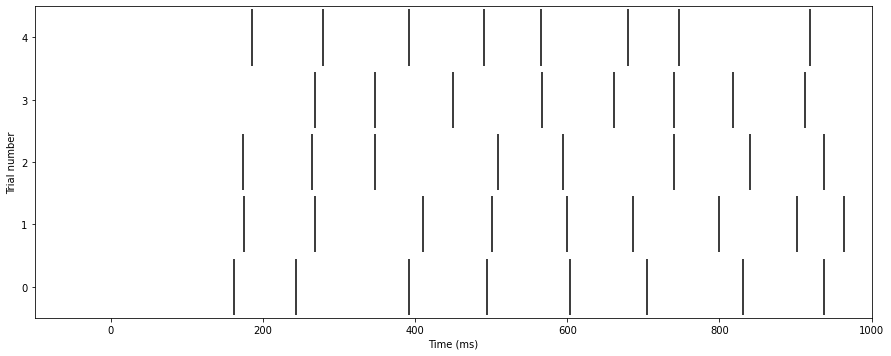

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(V1.T[:, i] == Vspike)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('Trial number')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

QUESTION: adjust $I_n$ and $I_0$ to get something that better matches the observed output:

I_0= 125.0


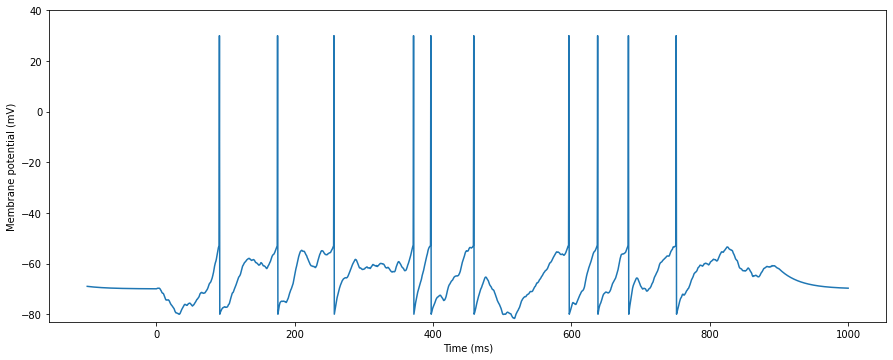

I_0= 168.75


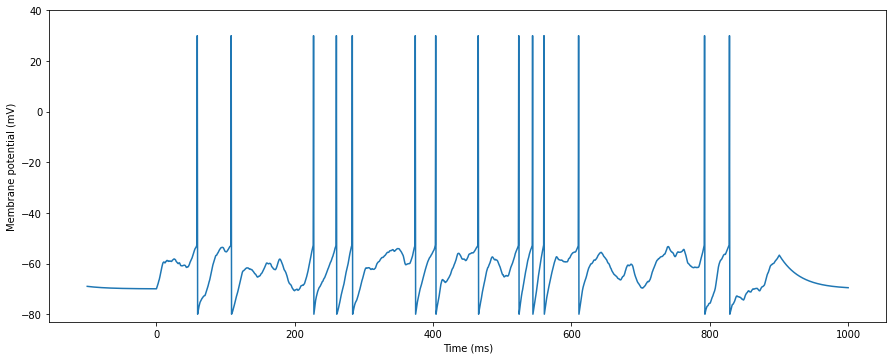

I_0= 212.5


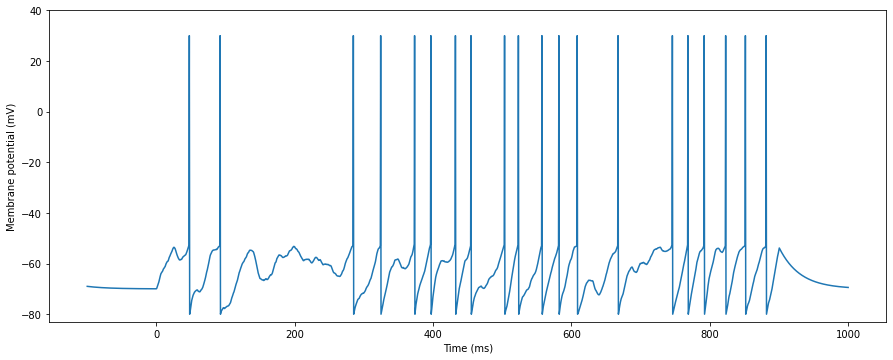

I_0= 256.25


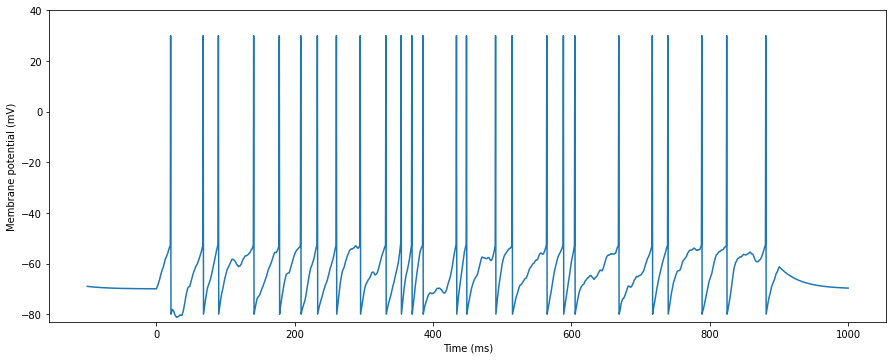

I_0= 300.0


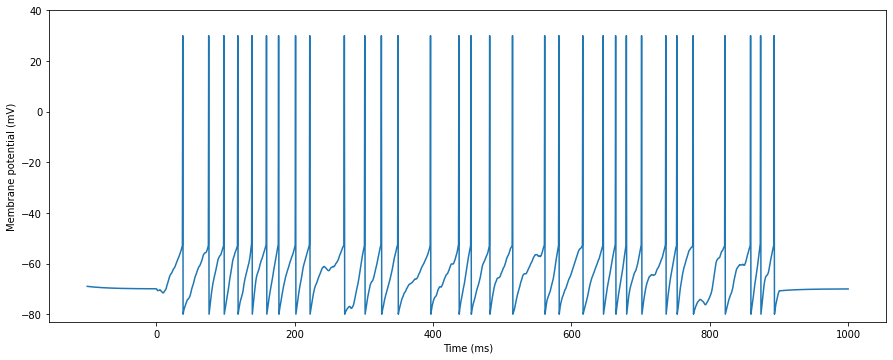

In [29]:
for rho in np.linspace(0.5, 1.2, 5):
    I_0_ = rho*250
    print('I_0=', I_0_)
    V= leaky_IF(time, genNoise(time, I_n=1000, I_0=I_0_))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("Membrane potential (mV)")
    ax.set_xlabel('Time (ms)')
    plt.show()

I_n= 300.0


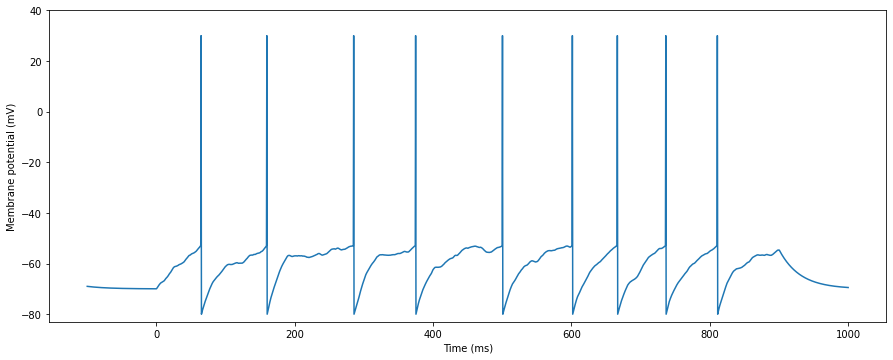

I_n= 399.99999999999994


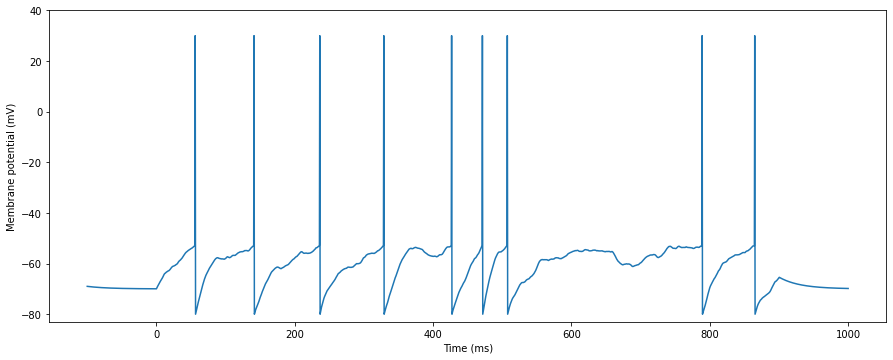

I_n= 500.0


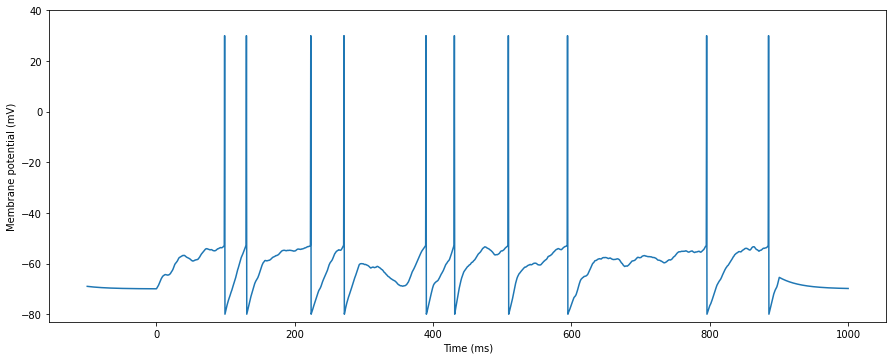

I_n= 600.0


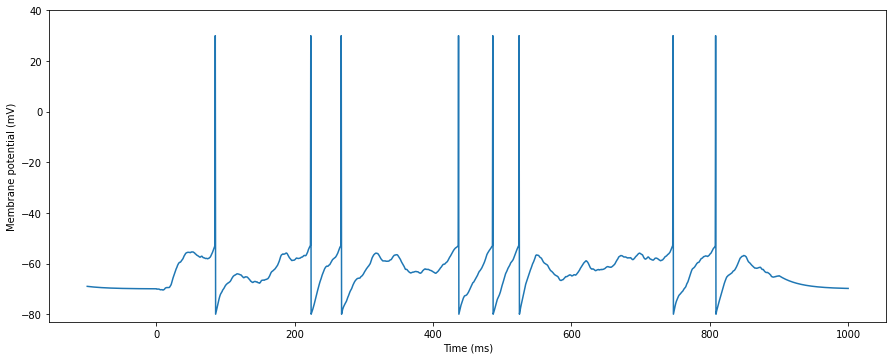

I_n= 700.0


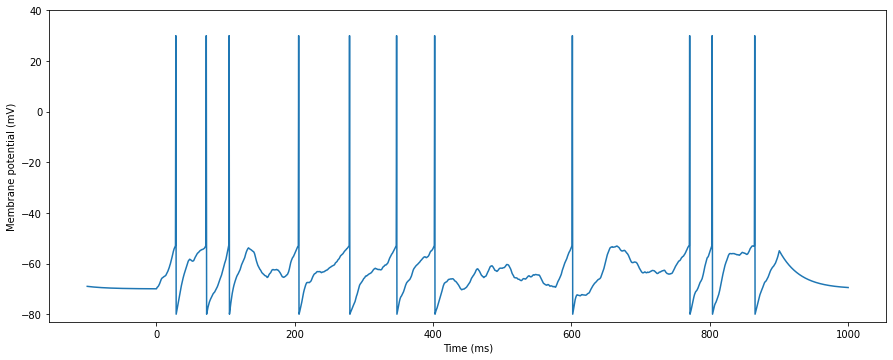

In [30]:
for rho in np.linspace(0.6, 1.4, 5):
    I_n_ = rho*500
    print('I_n=', I_n_)
    V= leaky_IF(time, genNoise(time, I_n=I_n_, I_0=150))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("Membrane potential (mV)")
    ax.set_xlabel('Time (ms)')

    plt.show()

QUESTION: Do we obtain something reproducible?

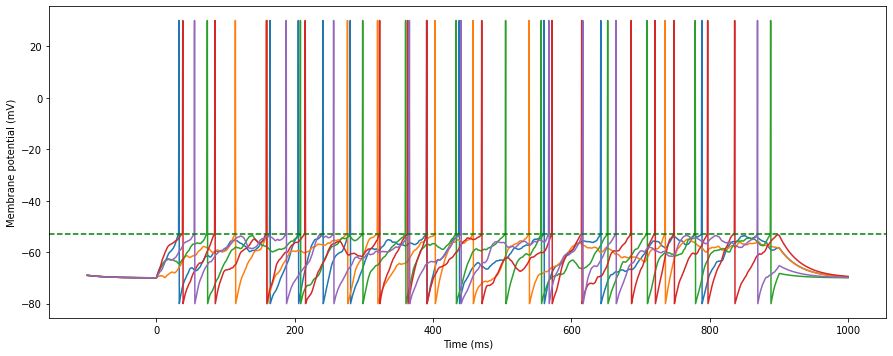

In [31]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, genNoise(time, I_n=500, I_0=150))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.axhline(Vthreshold, c='g', ls='--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)');

## "Frozen" noise?

QUESTION: what is the nature of the noise used in the article? why can it be described as [frozen noise] (https://www.oxfordreference.com/view/10.1093/oi/authority.20110803095836900)?

QUESTION: how to implement such a noise? what do you know about noise generators used in a computer?

In [32]:
help(np.random.seed)

Help on built-in function seed:

seed(...) method of numpy.random.mtrand.RandomState instance
    seed(self, seed=None)
    
    Reseed a legacy MT19937 BitGenerator
    
    Notes
    -----
    This is a convenience, legacy function.
    
    The best practice is to **not** reseed a BitGenerator, rather to
    recreate a new one. This method is here for legacy reasons.
    This example demonstrates best practice.
    
    >>> from numpy.random import MT19937
    >>> from numpy.random import RandomState, SeedSequence
    >>> rs = RandomState(MT19937(SeedSequence(123456789)))
    # Later, you want to restart the stream
    >>> rs = RandomState(MT19937(SeedSequence(987654321)))



In [33]:
np.random.randn()

1.2178438618842238

In [34]:
np.random.seed(42) # douglas adams
np.random.randn()

0.4967141530112327

In [35]:
np.random.randn()

-0.13826430117118466

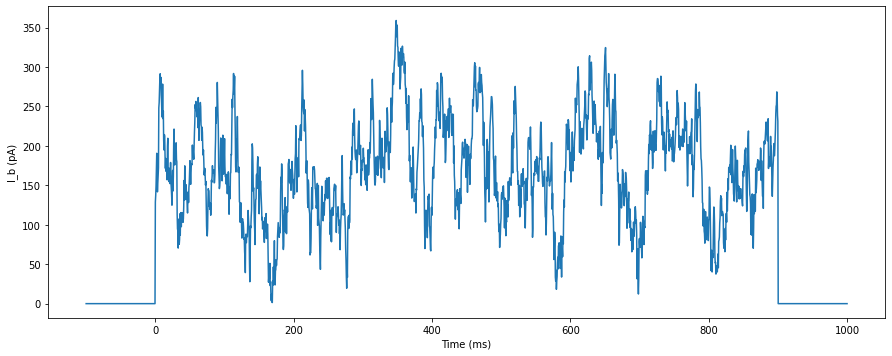

In [36]:
def genNoise(time=time, tau_n=10, I_n=400, I_0=150, seed=42, start=start, end=end):
    np.random.seed(seed)
    dt = time[1] - time[0]
    x=np.ones_like(time)
    for t in range(len(x)-1):
        n = np.random.randn()*I_n
        x[t+1] = (1-dt/tau_n)*x[t]+ (dt*n/tau_n)
    
    x += I_0
    x[time<start], x[time>end] = 0,0
    
    return x

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, genNoise())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

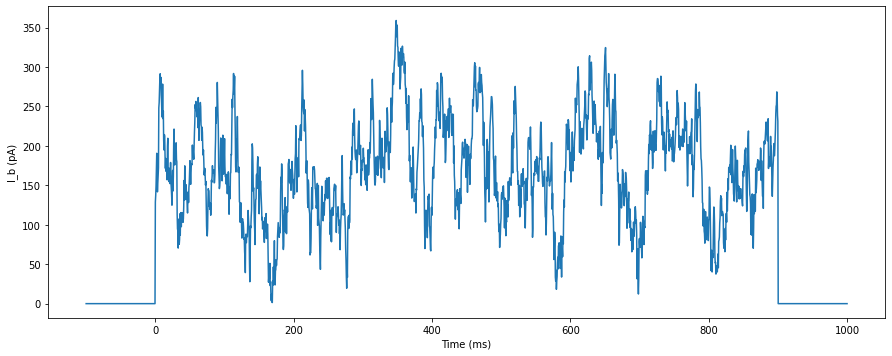

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, genNoise())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

## Multiple trials
Here we show the conservation of the time of the spikes using a noisy input (frozen noise)

QUESTION: adjust the parameter $I_0$ and $I_n$ to obtain about ten action potentials:

number of spikes per trial : [14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14]


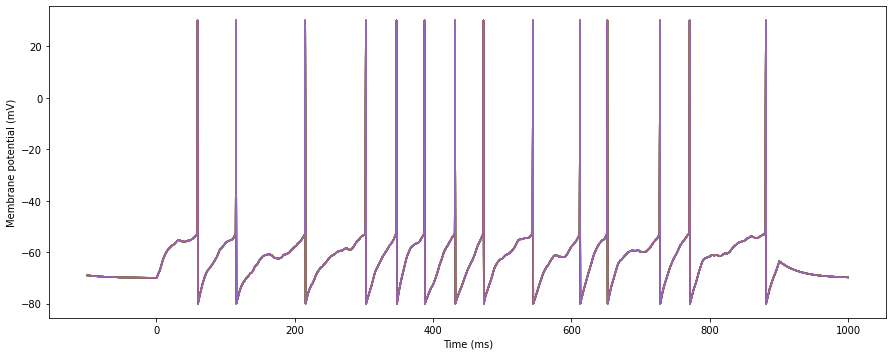

In [38]:
n_trials = 25
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, genNoise(I_n=400, I_0=150))

print('number of spikes per trial :', (V1>0).sum(axis=1))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)');

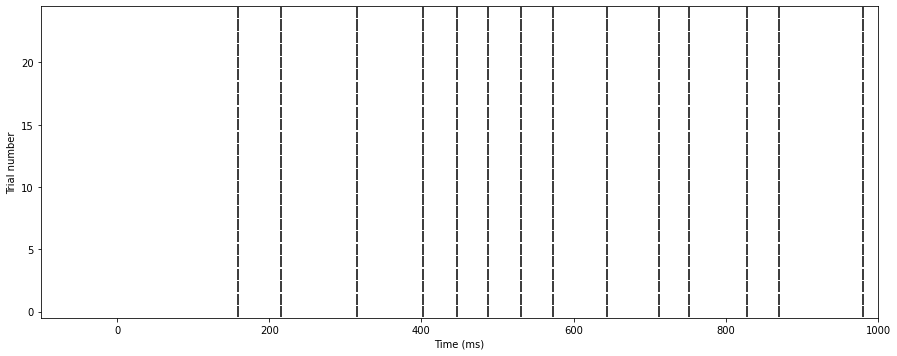

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(V1.T[:, i] == Vspike)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('Trial number')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

We reproduce panel B: with a frozen noise, the neuron traces are reproducible.

This also proves that we "forgot" to include a noise intrinsic to the dynamics of the neuron:

In [40]:
def leaky_IF(time=time, inp=I, tau=30, v0=-65, R=0.12, 
                Vthreshold =-53, Vreset=Vreset, Vspike=Vspike, 
                VRest=VRest, b=40, seed=None):
    np.random.seed(seed)
    V = np.ones_like(time)*v0
    dt = time[1] - time[0]
    for t in range(len(time)-1):
        n=np.random.randn()
        dV = dt * (-(V[t] - VRest) + R*(inp[t]+b*n))/tau
        V[t+1] = V[t] + dV
        
        if V[t]>Vthreshold:
            V[t+1]= Vspike
        if V[t] == Vspike:
            V[t+1]=Vreset
         
    return V


Several tests show that with a square wave the spike times lose their reproducibility, as shown in the figure:

QUESTION: adjust $I_0$ and $I_n$ to obtain a qualitatively similar number of spikes at the neuron output. To do this, try to control the number of spikes:

b = 50.0
number of spikes per trial : [10  9 10  9 10 10 10 10 10 10  9 10 11  9 10 10 10 10 10 10 10 10 10 10
 10]


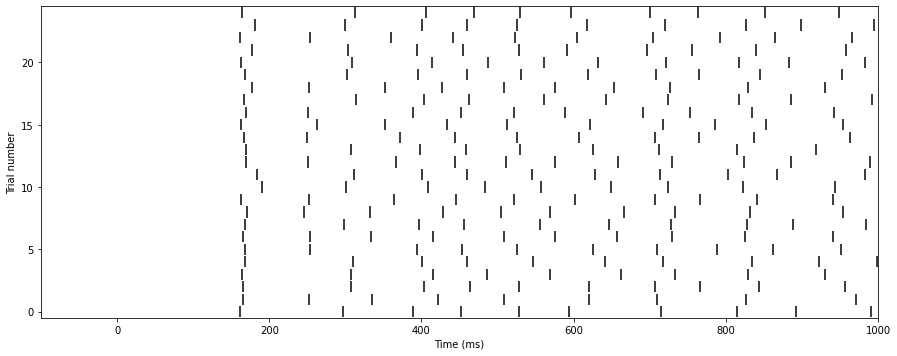

b = 87.5
number of spikes per trial : [10 10 10 10 10 10 11 10 10 11 11 11 11 10 10 11 10 10 11 10 11 10 10 11
 11]


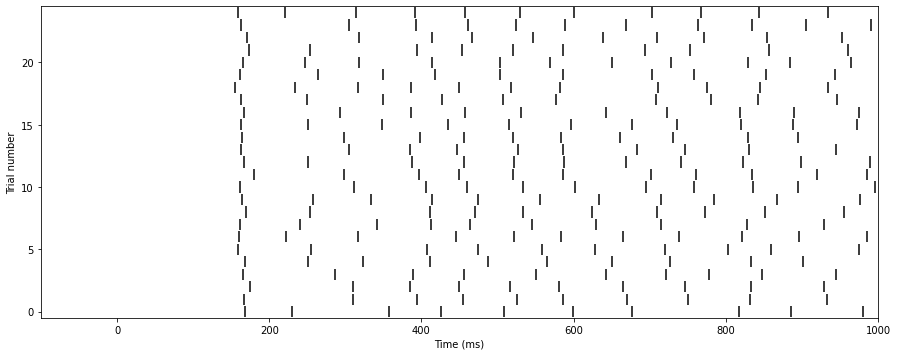

b = 125.0
number of spikes per trial : [10 10 10 11 11 10 10 11 11 10 11 12 11 11 11 10 10 10 11 12 10 11 11  9
 12]


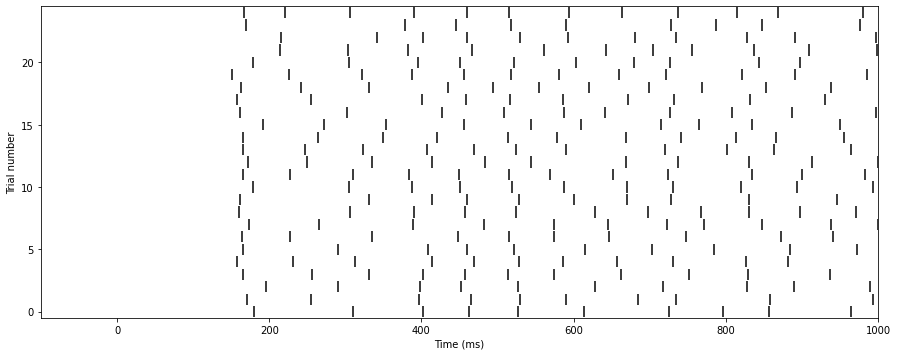

b = 162.5
number of spikes per trial : [11 10 12 12 10 12 12 11 12 12 12 11 11 10 12 11 11  9 12 11 12 10 11 10
 13]


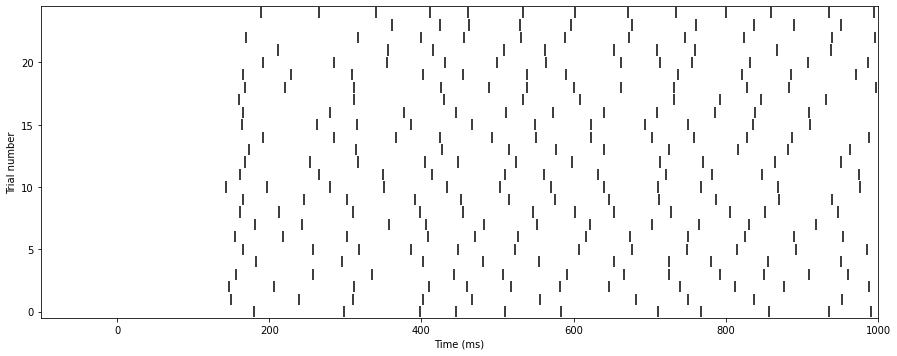

b = 200.0
number of spikes per trial : [11 12 11 13 11 12 12 13 11 11 13 11 13 11 11 12 12 11 12 11 10 13 12 12
 12]


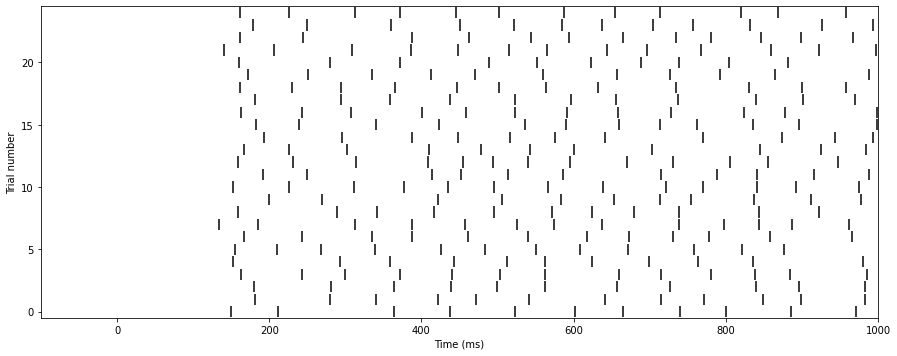

In [41]:
for rho in np.linspace(0.5, 2., 5):
    b_ = rho*100
    print('b =', b_)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, genNoise(I_n=100, I_0=150), b=b_)

    print('number of spikes per trial :', (VA>0).sum(axis=1))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.eventplot([dt*np.where(VA.T[:, i] == Vspike)[0] for i in range(0, n_trials)], 
                colors='black', lineoffsets=1, linelengths=0.9);
    ax.set_ylabel('Trial number')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim(time.min(), time.max())
    ax.set_ylim(-.5, n_trials-.5);
    plt.show()

I_n = 140.0
number of spikes per trial : [16 15 15 15 16 15 15 16 15 15 15 16 15 15 15 15 16 15 15 15 15 16 15 15
 15]


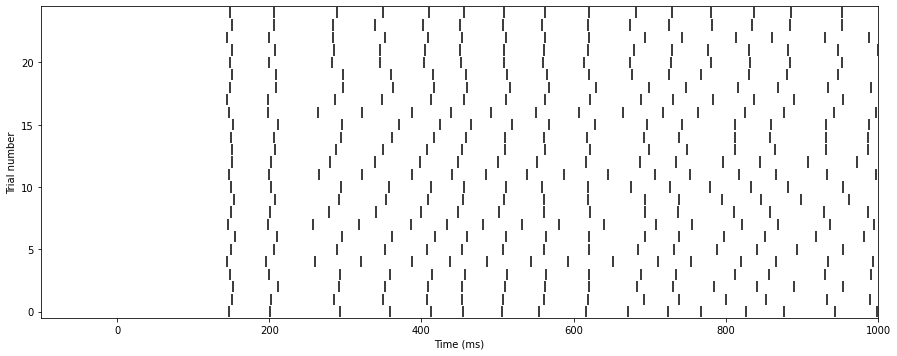

I_n = 170.0
number of spikes per trial : [16 16 16 15 15 16 15 16 15 16 16 15 15 15 15 15 15 15 15 15 15 15 15 16
 16]


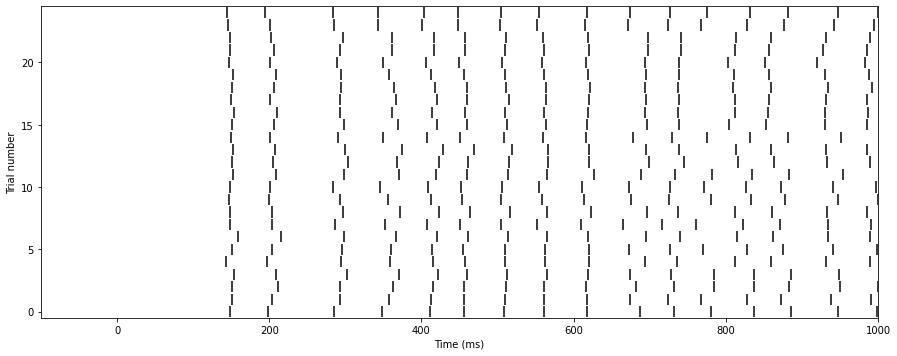

I_n = 200.0
number of spikes per trial : [16 16 16 16 15 15 16 16 15 16 15 15 16 16 15 16 16 16 15 15 15 16 16 15
 15]


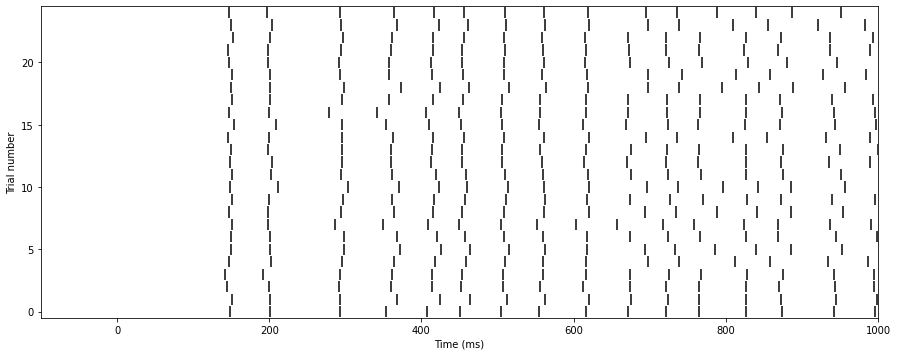

I_n = 229.99999999999997
number of spikes per trial : [16 16 16 15 16 16 15 16 16 15 16 16 16 15 16 16 15 16 15 16 15 16 16 16
 16]


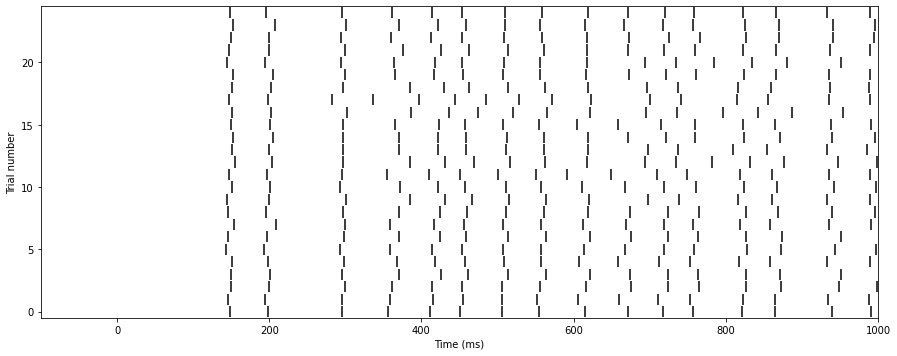

I_n = 260.0
number of spikes per trial : [16 16 16 16 16 16 16 16 16 16 17 16 16 15 16 16 16 16 17 15 16 16 16 15
 17]


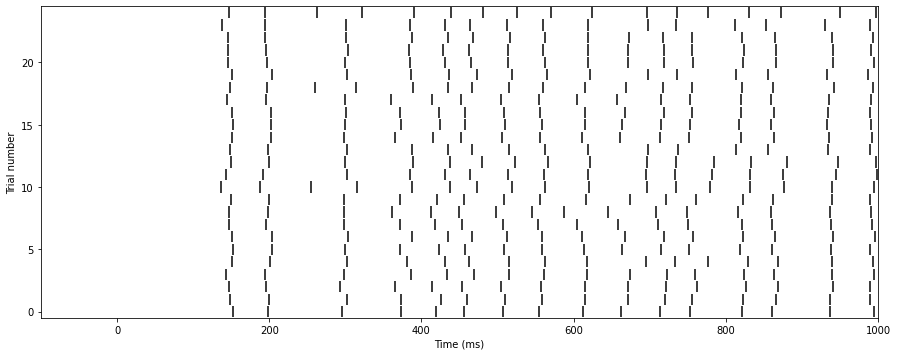

In [42]:
for rho in np.linspace(0.7, 1.3, 5):
    I_n_ = rho*200
    print('I_n =', I_n_)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, genNoise(I_n=I_n_, I_0=175))

    print('number of spikes per trial :', (VA>0).sum(axis=1))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.eventplot([dt*np.where(VA.T[:, i] == Vspike)[0] for i in range(0, n_trials)], 
                colors='black', lineoffsets=1, linelengths=0.9);
    ax.set_ylabel('Trial number')
    ax.set_xlabel('Time (ms)')
    ax.set_xlim(time.min(), time.max())
    ax.set_ylim(-.5, n_trials-.5);
    plt.show()

QUESTION: see the influence of $I_0$ on the behavior

rho= 0.7


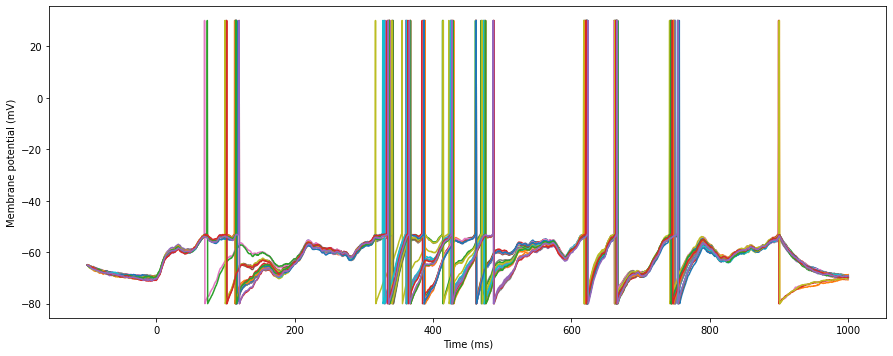

rho= 0.85


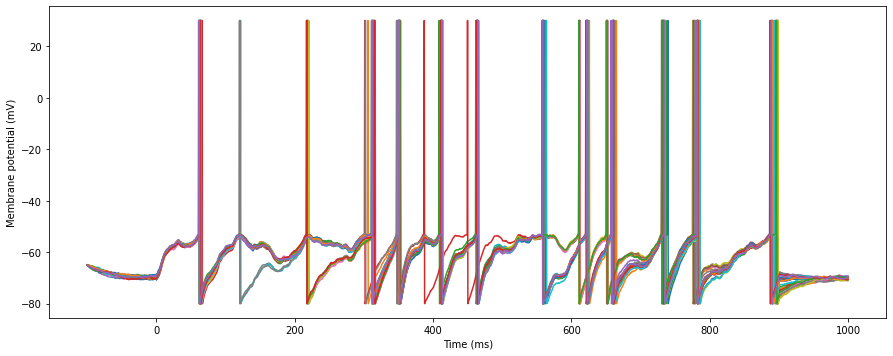

rho= 1.0


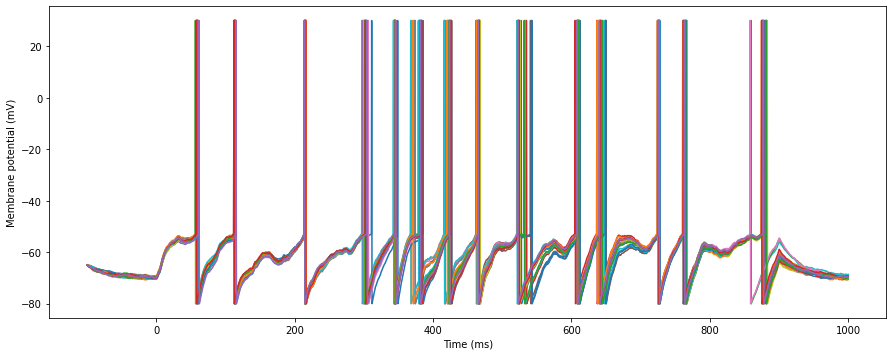

rho= 1.15


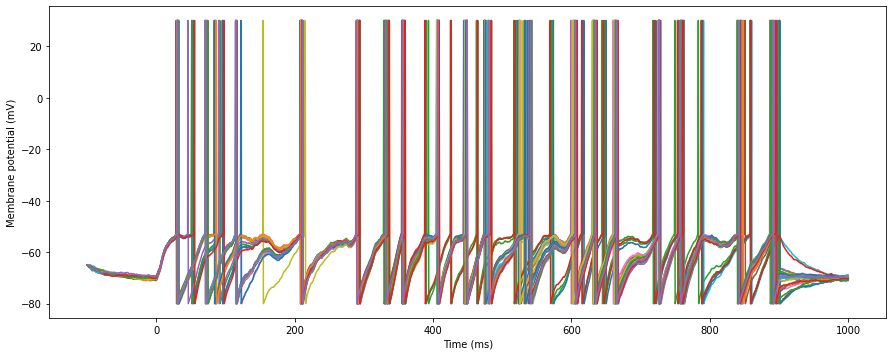

rho= 1.3


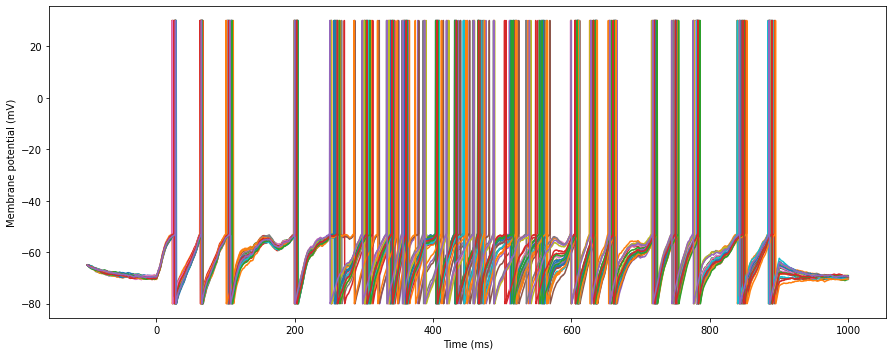

In [43]:
for rho in np.linspace(0.7, 1.3, 5):
    print('rho=', rho)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, genNoise(I_n=500, I_0=rho*150))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Membrane potential (mV)');
    plt.show()

QUESTION: see the influence of $I_0$ on the behavior, *when the noise amplitude is zero* :

I_0_= 135.0
number of spikes per trial : [2 1 2 1 2 1 2 2 2 2 3 2 2 1 1 3 0 1 2 3 2 2 2 1 1]


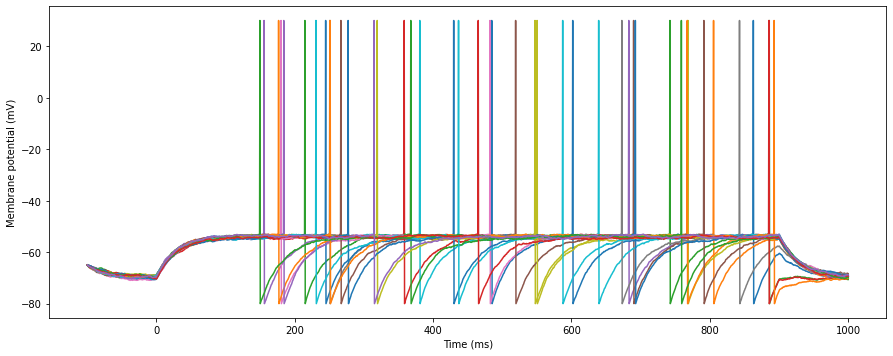

I_0_= 142.5
number of spikes per trial : [6 6 5 6 6 6 6 6 7 6 6 6 6 6 6 6 5 6 6 6 7 6 6 8 6]


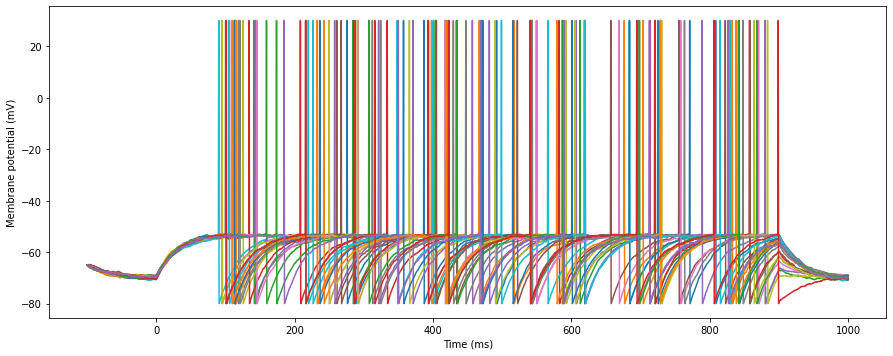

I_0_= 150.0
number of spikes per trial : [ 9  9  9  9  8  9  9  9  8  8  9  9  8  9 10  8  8  8  9  8  9  8  8  8
  9]


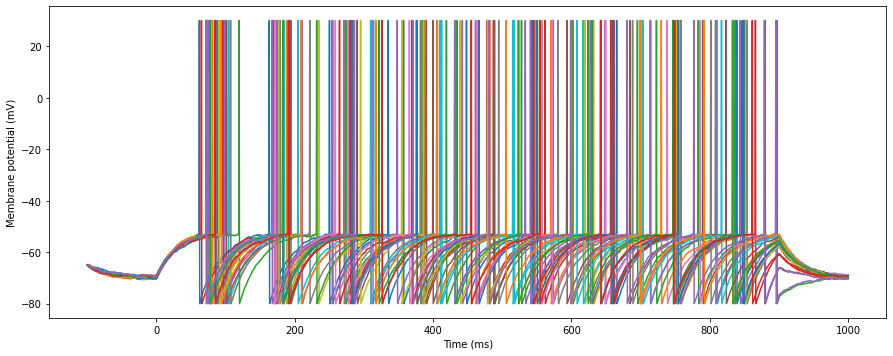

I_0_= 157.5
number of spikes per trial : [11 11 11 11 11 11 11 11 10 10 11 11 11 11 11 11 10 11 11 10 11 10 11 11
 11]


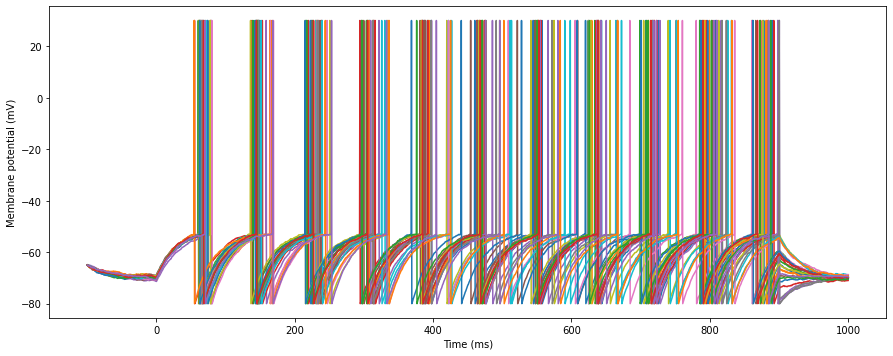

I_0_= 165.0
number of spikes per trial : [12 12 12 12 12 12 12 12 12 12 12 13 12 12 12 12 12 13 13 13 12 12 12 12
 12]


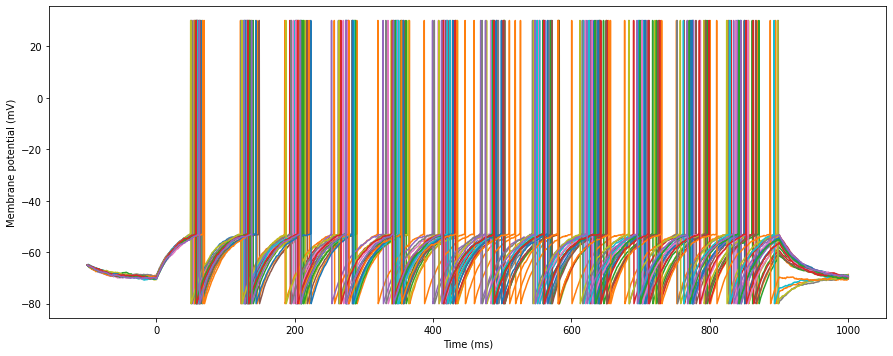

In [44]:
for rho in np.linspace(0.9, 1.1, 5):
    I_0_ = rho*150
    print('I_0_=', I_0_)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, genNoise(I_n=0, I_0=I_0_))

    print('number of spikes per trial :', (VA>0).sum(axis=1))
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Membrane potential (mV)');
    plt.show()

# Wrapping up

QUESTION: reproduce panel A: when the noise is zero, the traces of the neurons are not reproducible:

number of spikes per trial : [ 9  8  8  8  9  8  8  9  9  9  8  9  9  9  9  9  8  9  9  9 10  9  9  9
  8]


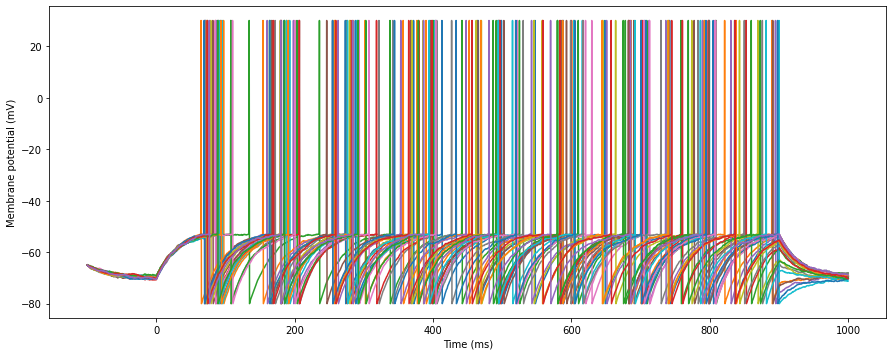

In [45]:
seed = 2020
VA = np.zeros((n_trials,len(time)))
b_A = genNoise(I_n=0, I_0=150, seed=seed)

for i in range(n_trials):
    VA[i, :] = leaky_IF(time, b_A)


print('number of spikes per trial :', (VA>0).sum(axis=1))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, VA.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)');

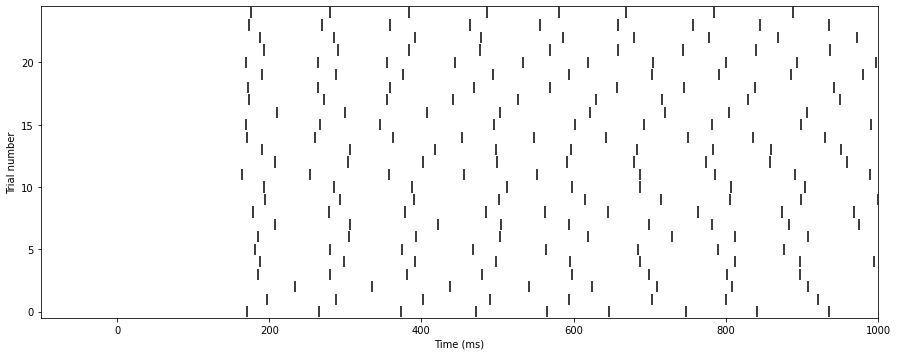

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(VA.T[:, i] == Vspike)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('Trial number')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

QUESTION: reproduce panel B: with frozen noise, the neuron traces are reproducible, even when the neuron has intrinsic noise:

number of spikes per trial : [16 17 17 17 17 16 16 17 17 17 16 17 16 17 17 17 17 17 17 17 17 17 17 17
 17]


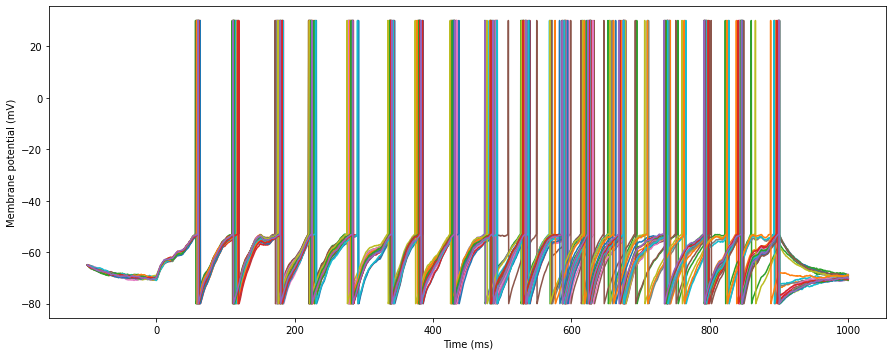

In [47]:
VB = np.zeros((n_trials, len(time)))
b_B = genNoise(I_n=300, I_0=195, seed=seed)
for i in range(n_trials):
    VB[i, :] = leaky_IF(time, b_B)

print('number of spikes per trial :', (VB>0).sum(axis=1))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, VB.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)');

To sum up:

<ipython-input-48-d909906c9eda>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[2][0].pcolor(time, range(n_trials), VA, vmax=Vthreshold)
<ipython-input-48-d909906c9eda>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[2][1].pcolor(time, range(n_trials), VB, vmax=Vthreshold)


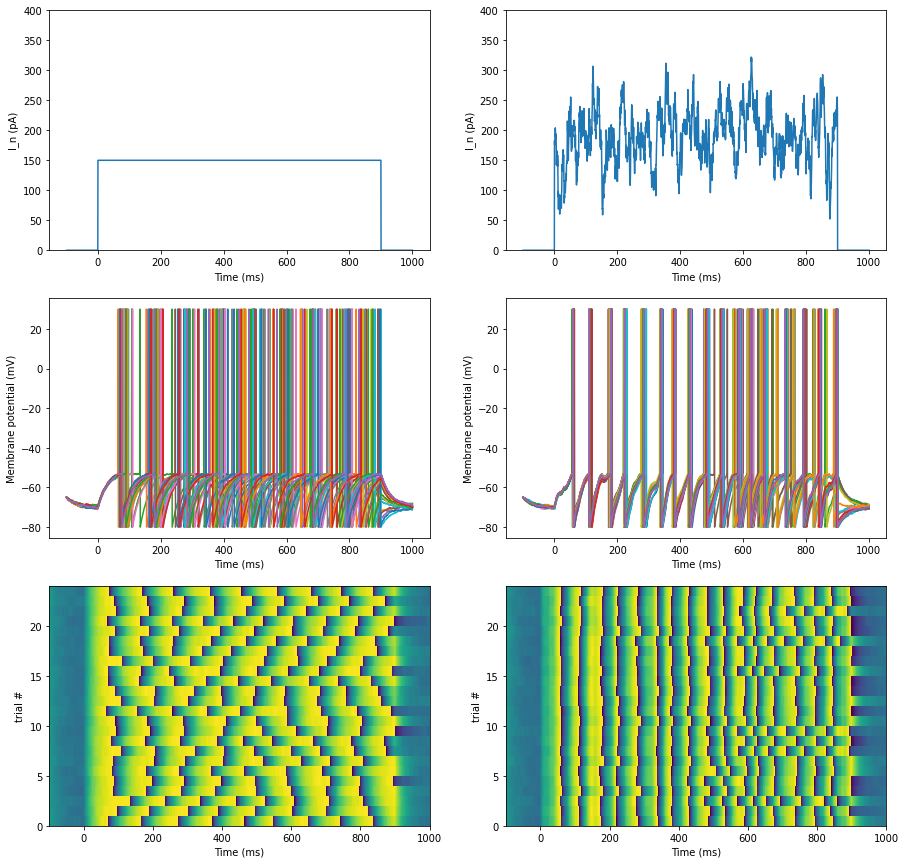

In [48]:
fig, axs = plt.subplots(3, 2, figsize=(fig_width, fig_width))

axs[0][0].plot(time, b_A)
axs[0][1].plot(time, b_B)
axs[1][0].plot(time, VA.T)
axs[1][1].plot(time, VB.T)
axs[2][0].pcolor(time, range(n_trials), VA, vmax=Vthreshold)
axs[2][1].pcolor(time, range(n_trials), VB, vmax=Vthreshold)
for ax in axs.ravel(): 
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Membrane potential (mV)');
axs[2][0].set_ylabel('trial #');
axs[2][1].set_ylabel('trial #');
for i in range(2):
    axs[0][i].set_ylabel('I_n (pA)')
    axs[0][i].set_ylim(0, 400);

QUESTION: conclude quickly: to what extent has the phenomenon been explained? What is the conclusion about the response of neurons to different dynamical signals?